In [74]:
import networkx as nx
from networkx import algorithms
from networkx.algorithms import community
import cudaq
from cudaq import spin
from cudaq.qis import *
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import numpy as np
import os
import time
import scipy.sparse as sp
from typing import Tuple

In [75]:
# Set base directory
base_dir = '/mnt/c/Users/rames102/Desktop/Codes'

# Set the path to vrp-matrices directory
vrp_matrices_dir = os.path.join(base_dir, 'vrp_matrices_qubo/TestSet')

# Full path to the .rudy file
rudy_file_path = os.path.join(vrp_matrices_dir, 'test_pb_10_o.rudy')

# Check if the file exists
if not os.path.isfile(rudy_file_path):
    raise FileNotFoundError(f"No such file or directory: '{rudy_file_path}'")

# Parse the data contents into lines one by one
with open(rudy_file_path, 'r') as f:
    lines = f.readlines()
    # Do not save if starting with #
    for line in lines:
    #     if line.startswith('#'):
    #         continue
        # else:
            print(line)

# Generated 2024-11-28 21:58:00.190076

# Constant term of objective = 66363.47

# Diagonal terms

0 0 -5530.29

1 1 -11060.58

2 2 -11060.58

3 3 -11060.58

4 4 -5530.29

5 5 -10505.93

6 6 -5530.29

7 7 -10523.10

8 8 -5530.29

9 9 -6623.42

# Off-Diagonal terms

5 7  11060.58

5 8  11060.58

5 9  11060.58

6 7  11060.58

7 9  11060.58


In [81]:
# Convert the abiove rudy file which has the diagonal and off diagonal terms of qubo Q matrix into a qubo Q matirx

def parse_rudy_to_qubo(rudy_file: str) -> Tuple[np.ndarray, float]:
    """
    Parse a .rudy file to extract QUBO problem data.
    """
    with open(rudy_file, 'r') as file:
        lines = file.readlines()
    
    # Initialize placeholders
    constant = 0
    diagonal_terms = []
    off_diagonal_terms = []
    max_index = 0
    
    for line in lines:
        line = line.strip() # Remove leading/trailing whitespaces

        # Skip comment lines
        if not line or line.startswith("#"): # Skip empty lines and comments
            # Extract constant term
            if "Constant term of objective" in line:
                constant = float(line.split("=")[-1].strip())
            continue  # Skip further processing of this line
        
        # Parse terms
        terms = line.split() # Split by whitespace. E.g. "0 0 1.0" -> ["0", "0", "1.0"]

        # Check if the term is diagonal or off-diagonal
        if terms[0] == terms[1]:  # Diagonal terms
            i = int(terms[0])
            max_index = max(max_index, i) # Update max index
            diagonal_terms.append((i, float(terms[2]))) # Append (index, value) tuple
        else:  # Off-diagonal terms
            i, j = int(terms[0]), int(terms[1])
            max_index = max(max_index, i, j)
            off_diagonal_terms.append((i, j, float(terms[2])))
        
        print(f"Diagonal terms: {diagonal_terms}")
        print(f"Off-diagonal terms: {off_diagonal_terms}")
 
    # Construct Q matrix
    n = max_index + 1 # Number of variables (0-indexed)
    Q = np.zeros((n, n), dtype=np.float64)
    
    for i, value in diagonal_terms:
        Q[i, i] = value
    
    for i, j, value in off_diagonal_terms:
        Q[i, j] = value  # Ensure symmetry
        Q[j, i] = value  # Ensure symmetry
    
    return Q, constant

In [82]:
# Get the QUBO data

Q, constant = parse_rudy_to_qubo(rudy_file_path)

# Print or save the QUBO data
print("QUBO Matrix (Q):")
print(Q)
print("Constant (c):", constant)
print("QUBO Matrix shape:", Q.shape)


Diagonal terms: [(0, -5530.29)]
Off-diagonal terms: []
Diagonal terms: [(0, -5530.29), (1, -11060.58)]
Off-diagonal terms: []
Diagonal terms: [(0, -5530.29), (1, -11060.58), (2, -11060.58)]
Off-diagonal terms: []
Diagonal terms: [(0, -5530.29), (1, -11060.58), (2, -11060.58), (3, -11060.58)]
Off-diagonal terms: []
Diagonal terms: [(0, -5530.29), (1, -11060.58), (2, -11060.58), (3, -11060.58), (4, -5530.29)]
Off-diagonal terms: []
Diagonal terms: [(0, -5530.29), (1, -11060.58), (2, -11060.58), (3, -11060.58), (4, -5530.29), (5, -10505.93)]
Off-diagonal terms: []
Diagonal terms: [(0, -5530.29), (1, -11060.58), (2, -11060.58), (3, -11060.58), (4, -5530.29), (5, -10505.93), (6, -5530.29)]
Off-diagonal terms: []
Diagonal terms: [(0, -5530.29), (1, -11060.58), (2, -11060.58), (3, -11060.58), (4, -5530.29), (5, -10505.93), (6, -5530.29), (7, -10523.1)]
Off-diagonal terms: []
Diagonal terms: [(0, -5530.29), (1, -11060.58), (2, -11060.58), (3, -11060.58), (4, -5530.29), (5, -10505.93), (6, -553

In [83]:
# def qubo_to_maxcut(Q):
#     """
#     Transform a QUBO problem into a MaxCut problem on K_{n+1}.
#     Args:
#         Q (np.ndarray): QUBO matrix of size n x n.
#     Returns:
#         G (nx.Graph): Weighted complete graph K_{n+1}.
#         C (float): Constant for converting MaxCut solution to QUBO value.
#     """
#     n = Q.shape[0]
#     G = nx.Graph()  # Create an empty graph
    
#     # Add nodes
#     G.add_nodes_from(range(n + 1))
    
#     # Add weights for edges (i, j) with i, j > 0
#     for i in range(1, n + 1):
#         for j in range(i + 1, n + 1):
#             wij = Q[i - 1, j - 1] + Q[j - 1, i - 1]
#             if wij != 0:
#                 G.add_edge(i, j, weight=wij)
    
#     # Add weights for edges (i, 0) with i > 0
#     for i in range(1, n + 1):
#         wi0 = sum(Q[i - 1, j] + Q[j, i - 1] for j in range(n))  
#         G.add_edge(i, 0, weight=wi0)

#     # Calculate constant C
#     sum_weights = sum(data['weight'] for _, _, data in G.edges(data=True))
#     trace_Q = sum(Q[i,i] for i in range(n))
#     sym_sum_Q = sum(Q[i,j] + Q[j,i] for i in range(n) for j in range(i + 1, n))
#     C = 1/4 *(sum_weights + 2*trace_Q + sym_sum_Q)
    
#     return G, C

# # Convert QUBO to MaxCut
# G, C = qubo_to_maxcut(Q)

In [84]:
# # Plot the graph
# plt.figure(figsize=(12, 8))

# # Define the layout for the graph
# pos = nx.spring_layout(G)

# # Draw nodes
# nx.draw_networkx_nodes(G, pos, node_size=70, node_color="skyblue")

# # Draw edges
# nx.draw_networkx_edges(G, pos, edgelist=G.edges, width=1, edge_color="black")

# # Add labels for nodes
# nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# # Add labels for edges (weights)
# edge_labels = {(u, v): f"{data['weight']:.2f}" for u, v, data in G.edges(data=True)}
# # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# # Display the graph
# plt.title("MaxCut Problem as a Graph")
# plt.axis("off")
# plt.show()

In [85]:
# Q = np.array([[1,0,0],[0,-1,0],[0,0,1]])
print(Q)

[[ -5530.29      0.        0.        0.        0.        0.        0.
       0.        0.        0.  ]
 [     0.   -11060.58      0.        0.        0.        0.        0.
       0.        0.        0.  ]
 [     0.        0.   -11060.58      0.        0.        0.        0.
       0.        0.        0.  ]
 [     0.        0.        0.   -11060.58      0.        0.        0.
       0.        0.        0.  ]
 [     0.        0.        0.        0.    -5530.29      0.        0.
       0.        0.        0.  ]
 [     0.        0.        0.        0.        0.   -10505.93      0.
   11060.58  11060.58  11060.58]
 [     0.        0.        0.        0.        0.        0.    -5530.29
   11060.58      0.        0.  ]
 [     0.        0.        0.        0.        0.    11060.58  11060.58
  -10523.1       0.    11060.58]
 [     0.        0.        0.        0.        0.    11060.58      0.
       0.    -5530.29      0.  ]
 [     0.        0.        0.        0.        0.    11060.58      0.

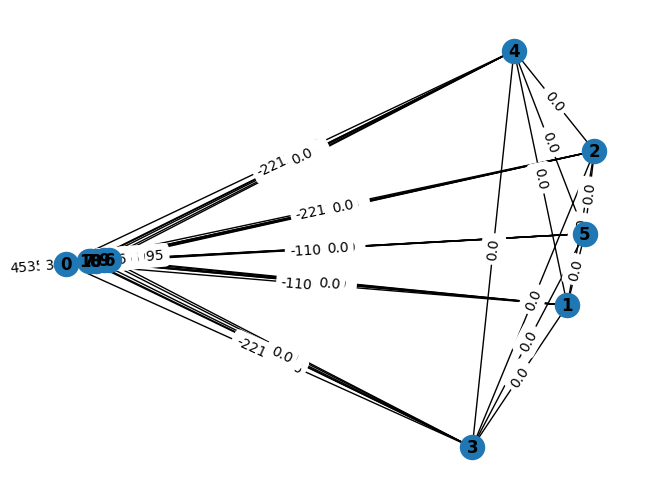

In [86]:
def qubo_to_maxcut(Q):
    n = Q.shape[0]
    G = nx.complete_graph(n + 1)
    
    # Define weights for edges in Kn+1
    for i in range(1, n + 1):
        for j in range(1, n + 1):
            if i != j:
                G[i][j]['weight'] = Q[i-1, j-1] + Q[j-1, i-1]
    
    for i in range(1, n + 1):
        G[0][i]['weight'] = sum(Q[i-1, j] + Q[j, i-1] for j in range(n))
    
    return G

# plot the graph G as a networkx graph with edge weights
G = qubo_to_maxcut(Q)
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [87]:
# Identifying and setting target

targets = cudaq.get_targets()
# for target in targets: 
#    print(target)
cudaq.set_target("qpp-cpu") # nvidia-fp64
# cudaq.set_target("nvidia", option="mqpu")
target = cudaq.get_target()
# num_qpus = target.num_qpus()
# print("Number of GPUs:", num_qpus)

In [88]:
# # Graph Definition

sampleGraph3 = qubo_to_maxcut(Q)

# print only the diagonal elements of the Q matrix along with the indices
print("Diagonal elements of Q matrix:")
for i in range(Q.shape[0]):
    print(f"Q[{i}, {i}] = {Q[i, i]}")

print("Graph nodes:", sampleGraph3.nodes)
print("Graph edges:", sampleGraph3.edges)
print("Graph edge weights:", nx.get_edge_attributes(sampleGraph3, 'weight'))

Diagonal elements of Q matrix:
Q[0, 0] = -5530.29
Q[1, 1] = -11060.58
Q[2, 2] = -11060.58
Q[3, 3] = -11060.58
Q[4, 4] = -5530.29
Q[5, 5] = -10505.93
Q[6, 6] = -5530.29
Q[7, 7] = -10523.1
Q[8, 8] = -5530.29
Q[9, 9] = -6623.42
Graph nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Graph edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (6, 7), (6, 8), (6, 9), (6, 10), (7, 8), (7, 9), (7, 10), (8, 9), (8, 10), (9, 10)]
Graph edge weights: {(0, 1): np.float64(-11060.58), (0, 2): np.float64(-22121.16), (0, 3): np.float64(-22121.16), (0, 4): np.float64(-22121.16), (0, 5): np.float64(-11060.58), (0, 6): np.float64(45351.619999999995), (0, 7): np.float64(11060.58), (0, 8): np.float6

In [89]:
# Define a function to generate the Hamiltonian for a weighted max cut problem using the graph G

def hamiltonian_max_cut(sources : List[int], targets : List[int], weights : List[float]): 
    """Hamiltonian for finding the max cut for the graph  with edges defined by the pairs generated by source and target edges
        
    Parameters
    ----------
    sources: List[int] 
        list of the source vertices for edges in the graph
    targets: List[int]
        list of the target vertices for the edges in the graph
    weights : List[float]
        list of the weight of the edge determined by the source and target with the same index
    Returns
    -------
    cudaq.SpinOperator
        Hamiltonian for finding the max cut of the graph defined by the given edges
    """
    hamiltonian = 0
    # Since our vertices may not be a list from 0 to n, or may not even be integers,
    
    for i in range(len(sources)):
        # Add a term to the Hamiltonian for the edge (u,v)
        qubitu = sources[i]
        qubitv = targets[i]
        edge_weight = weights[i]
        hamiltonian += 0.5*edge_weight*(spin.z(qubitu)*spin.z(qubitv)-spin.i(qubitu)*spin.i(qubitv))
    
    return hamiltonian

In [90]:
# QAOA kernels

# Problem kernel
@cudaq.kernel
def qaoaProblem(qubit_0 : cudaq.qubit, qubit_1 : cudaq.qubit, alpha : float):
    """Build the QAOA gate sequence between two qubits that represent an edge of the graph
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit representing the first vertex of an edge
    qubit_1: cudaq.qubit
        Qubit representing the second vertex of an edge
    alpha: float
        Free variable

    """
    x.ctrl(qubit_0, qubit_1)
    rz(2.0*alpha, qubit_1)
    x.ctrl(qubit_0, qubit_1)

# Mixer kernel
@cudaq.kernel
def qaoaMixer(qubit_0 : cudaq.qubit, beta : float):
    """Build the QAOA gate sequence that is applied to each qubit in the mixer portion of the circuit
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit
    beta: float
        Free variable

    """
    rx(2.0*beta, qubit_0)

In [91]:
# Define the QAOA circuit: # The QAOA circuit for max cut depends on the structure of the graph!

@cudaq.kernel
def kernel_qaoa(qubit_count :int, layer_count: int, edges_src: List[int], edges_tgt: List[int], thetas : List[float]):
    """Build the QAOA circuit for max cut of the graph with given edges and nodes
    Parameters
    ----------
    qubit_count: int
        Number of qubits in the circuit, which is the same as the number of nodes in our graph
    layer_count : int
        Number of layers in the QAOA kernel
    edges_src: List[int]
        List of the first (source) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    edges_tgt: List[int]
        List of the second (target) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    thetas: List[float]
        Free variables to be optimized

    """

    # Allocate qubits
    qreg = cudaq.qvector(qubit_count)

    # Placing qubits in superposition
    h(qreg)

    # Each layer has two components: the problem kernel and the mixer
    for i in range(layer_count):
        # Add the problem kernel to each layer
        for edge in range(len(edges_src)):
            qubitu = edges_src[edge]
            qubitv = edges_tgt[edge]
            qaoaProblem(qreg[qubitu], qreg[qubitv], thetas[i])
        # Add mixer kernel to each layer
        for j in range(qubit_count):
            qaoaMixer(qreg[j], thetas[layer_count + i])          

In [92]:
# Find the optimal parameters for the QAOA circuit using classical optimization

def find_optimal_parameters(G, layer_count, seed):
    """Function for finding the optimal parameters of QAOA for the max cut of a graph
    Parameters
    ----------
    G: networkX graph 
        Problem graph whose max cut we aim to find
    layer_count : int 
        Number of layers in the QAOA circuit
    seed : int
        Random seed for reproducibility of results
        
    Returns
    -------
    list[float]
        Optimal parameters for the QAOA applied to the given graph G
    """
    parameter_count: int = 2 * layer_count

    # Problem parameters
    nodes = sorted(list(nx.nodes(G)))
    qubit_src = []
    qubit_tgt = []
    weights = []
    for u, v in nx.edges(G):
        # We can use the index() command to read out the qubits associated with the vertex u and v.
        qubit_src.append(nodes.index(u))
        qubit_tgt.append(nodes.index(v))
        weights.append(G.edges[u,v]['weight'])                                           
    # The number of qubits we'll need is the same as the number of vertices in our graph
    qubit_count : int = len(nodes)
    # Each layer of the QAOA kernel contains 2 parameters
    parameter_count : int = 2*layer_count
    
    # Specify the optimizer and its initial parameters. 
    optimizer = cudaq.optimizers.NelderMead()
    np.random.seed(seed)
    cudaq.set_random_seed(seed)
    optimizer.initial_parameters = np.random.uniform(-np.pi, np.pi,
                                                     parameter_count)   

    # Pass the kernel, spin operator, and optimizer to `cudaq.vqe`.
    optimal_expectation, optimal_parameters = cudaq.vqe(
        kernel=kernel_qaoa,
        spin_operator=hamiltonian_max_cut(qubit_src, qubit_tgt, weights),
        argument_mapper=lambda parameter_vector: (qubit_count, layer_count, qubit_src, qubit_tgt, parameter_vector),
        optimizer=optimizer,
        parameter_count=parameter_count)

    return optimal_parameters

In [93]:
# These functions are used to identify the subgraph
# that contains a given vertex, and identify the vertices of the parent graph
# that lie on the border of the subgraphs in the subgraph dictionary

def subgraph_of_vertex(graph_dictionary, vertex):
    """
    A function that takes as input a subgraph partition (in the form of a graph dictionary) and a vertex.
    The function should return the key associated with the subgraph that contains the given vertex.

    Parameters
    ----------
    graph_dictionary: dict of networkX.Graph with str as keys
    v : int
        v is a name for a vertex
    Returns
    -------
    str
        the key associated with the subgraph that contains the given vertex.
    """
    # in case a vertex does not appear in the graph_dictionary, return the empty string
    location = ''

    for key in graph_dictionary:
        if vertex in graph_dictionary[key].nodes():
            location = key
    return location

def border(G, subgraph_dictionary):
    """Build a graph made up of border vertices from the subgraph partition

    Parameters
    ----------
    G: networkX.Graph
        Graph whose max cut we want to find
    subgraph_dictionary: dict of networkX graph with str as keys
        Each graph in the dictionary should be a subgraph of G

    Returns
    -------
    networkX.Graph
        Subgraph of G made up of only the edges connecting subgraphs in the subgraph dictionary
    """
    borderGraph = nx.Graph()
    for u,v in G.edges():
        border = True
        for key in subgraph_dictionary:
            SubG = subgraph_dictionary[key]
            edges = list(nx.edges(SubG))
            if (u,v) in edges:
                border = False
        if border==True:
            borderGraph.add_edge(u,v)

    return borderGraph

In [94]:
# Returns the cut value of G based on the coloring of the nodes of G

def cutvalue(G):
    """Returns the cut value of G based on the coloring of the nodes of G
    
    Parameters
    ----------
    G: networkX.Graph 
        Graph with weighted edges and with binary value colors assigned to the vertices
    
    Returns
    -------
    int 
        cut value of the graph determined by the vertex colors and edge weights
    """  

    cut = 0
    for u, v in G.edges():
        if G.nodes[u]['color'] != G.nodes[v]['color']: 
            cut+=G.edges[u,v]['weight']
    return cut

In [95]:
# def qaoa_for_graph(G, layer_count, shots, seed):
#     """Function for finding the max cut of a graph using QAOA

#     Parameters
#     ----------
#     G: networkX graph
#         Problem graph whose max cut we aim to find
#     layer_count : int
#         Number of layers in the QAOA circuit
#     shots : int
#         Number of shots in the sampling subroutine
#     seed : int
#         Random seed for reproducibility of results

#     Returns
#     -------
#     str
#         Binary string representing the max cut coloring of the vertinces of the graph
#     """
#     if nx.number_of_nodes(G) ==1 or nx.number_of_edges(G) ==0:
#         # The first condition implies the second condition so we really don't need
#         # to consider the case nx.number_of_nodes(G) ==1
#         results = ''
#         for u in list(nx.nodes(G)):
#             np.random.seed(seed)
#             random_assignment = str(np.random.randint(0, 1))
#             results+=random_assignment

#     else:
#         parameter_count: int = 2 * layer_count

#         # Problem parameters
#         nodes = sorted(list(nx.nodes(G)))
#         qubit_src = []
#         qubit_tgt = []
#         for u, v in nx.edges(G):
#             # We can use the index() command to read out the qubits associated with the vertex u and v.
#             qubit_src.append(nodes.index(u))
#             qubit_tgt.append(nodes.index(v))
#         # The number of qubits we'll need is the same as the number of vertices in our graph
#         qubit_count : int = len(nodes)
#         # Each layer of the QAOA kernel contains 2 parameters
#         parameter_count : int = 2*layer_count

#         optimal_parameters = find_optimal_parameters(G, layer_count, seed)

#         # Print the optimized parameters
#         print("Optimal parameters = ", optimal_parameters)

#         # Sample the circuit
#         counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, qubit_src, qubit_tgt, optimal_parameters, shots_count=shots)
#         # print('most_probable outcome = ',counts.most_probable())
#         print('counts = ', counts)
#         # results = str(counts.most_probable())
#         results = str(counts)
        
    # return results

def qaoa_for_graph(G, layer_count, shots, seed):
    """Function for finding the max cut of a graph using QAOA.

    Parameters
    ----------
    G: networkX graph
        Problem graph whose max cut we aim to find.
    layer_count : int
        Number of layers in the QAOA circuit.
    shots : int
        Number of shots in the sampling subroutine.
    seed : int
        Random seed for reproducibility of results.

    Returns
    -------
    dict
        Dictionary where keys are binary strings (solutions), and values are counts or probabilities.
    """
    if nx.number_of_nodes(G) == 1 or nx.number_of_edges(G) == 0:
        # For trivial graphs, assign random binary values to nodes
        results = {}
        for u in list(nx.nodes(G)):
            np.random.seed(seed)
            random_assignment = np.random.randint(0, 2)  # Binary value (0 or 1)
            results[u] = random_assignment
        return results

    else:
        # Prepare the problem graph for QAOA
        nodes = sorted(list(nx.nodes(G)))
        qubit_src = []
        qubit_tgt = []
        for u, v in nx.edges(G):
            qubit_src.append(nodes.index(u))
            qubit_tgt.append(nodes.index(v))

        # Find optimal parameters for QAOA
        optimal_parameters = find_optimal_parameters(G, layer_count, seed)
        print("Optimal parameters = ", optimal_parameters)

        # Sample the QAOA circuit
        counts = cudaq.sample(
            kernel_qaoa, len(nodes), layer_count, qubit_src, qubit_tgt, optimal_parameters, shots_count=shots
        )
        print("Counts = ", counts)

        # Convert counts to a dictionary of all results
        all_results = {
            bitstring: count for bitstring, count in counts.items()
        }

        return all_results

In [96]:
# QAOA Divide and Conquer: Divide the graph into subgraphs. Make it recursive and we will apply the divide stage of the algorithm to any subgraph that has more than 14 vertices

# Function to return a dictionary of subgraphs of the input graph using the greedy modularity maximization algorithm

# Weighted graph partitioning

def subgraphpartition(G,n, name, globalGraph):
    """Divide the graph up into at most n subgraphs
    
    Parameters
    ----------
    G: networkX.Graph 
        Graph that we want to subdivivde which lives inside of or is equatl to globalGraph
    n : int
        n is the maximum number of subgraphs in the partition
    name : str
        prefix for the graphs (in our case we'll use 'Global')
    globalGraph: networkX.Graph
        original problem graph
        
    Returns
    -------
    dict of str : networkX.Graph
        Dictionary of networkX graphs with a string as the key
    """
    greedy_partition = community.greedy_modularity_communities(G, weight='weight', resolution=1.1, cutoff=1, best_n=n)
    number_of_subgraphs = len(greedy_partition)

    graph_dictionary = {}
    graph_names=[]
    for i in range(number_of_subgraphs):
        subgraphname=name+':'+str(i)
        graph_names.append(subgraphname)

    for i in range(number_of_subgraphs):
        nodelist = sorted(list(greedy_partition[i]))
        graph_dictionary[graph_names[i]] = nx.subgraph(globalGraph, nodelist)
     
    return(graph_dictionary) 

In [97]:
# We plot the subgraphs below in different colors to visualize the subdivision of the graph
# However, edges that connect vertices in distinct subgraphs in subgraph_dictionary are not drawn.

num_qubits_subgraph = 14 # maximum number of vertices in a subgraph
n = 12 # maximum number of subgraphs in a subgraph partitioning
def recursive_partition(G,name, global_graph):
    """Divide the graph up into subgraphs of at most num_qubits vertices recursively

    Parameters
    ----------
    G: networkX.Graph
        Graph that we want to subdivide which is a subgraph of global_graph
    name : str
        prefix for the graphs (in our case we'll use 'Global')
    global_graph : networkX.Graph
        parent graph

    Returns
    -------
    dict of str : networkX.Graph
        Dictionary of networkX graphs with a string as the key
    """
    if nx.number_of_nodes(G)<num_qubits_subgraph+1:
        print('Graph',name,'has',len(nx.nodes(G)),'vertices.')
    else:
        max_num_subgraphs = min(n, nx.number_of_nodes(G))
        new_subgraphs = subgraphpartition(G, max_num_subgraphs, name, global_graph)
        for key in new_subgraphs:
            recursive_partition(new_subgraphs[key],key, global_graph)

# Apply the partitioning function to the sampleGraph3
recursive_partition(sampleGraph3, 'Global', sampleGraph3)

Graph Global has 11 vertices.


In [98]:
# We want to swap colors in such a way that we can add as many of the edges of borderGraph into a cut of sampleGraph2 as possible without sacrificing too many edges from the unaltered cut
# This new optimization problem involves deciding whether or not to flip the colors of each subgraph
# For each possible color change of subgraphs, we'll compute a "gain" from changing the colors
# This gain is the number of border edges added to the cut from the alteration minus the number of border edges originally in the unaltered cut that are no longer in the cut after the color change
# We want to maximize this gain

# Define the mergerGraph and color code the vertices
# according to the subgraph that the vertex represents
# we're collapsing all the vertices in a subgraph down to just one vertex in mergerGraph

def createMergerGraph(border, subgraphs):
    """Build a graph containing a vertex for each subgraph
    and edges between vertices are added if there is an edge between
    the corresponding subgraphs

    Parameters
    ----------
    border : networkX.Graph
        Graph of connections between vertices in distinct subgraphs
    subgraphs : dict of networkX graph with str as keys
        The nodes of border should be a subset of the the graphs in the subgraphs dictionary

    Returns
    -------
    networkX.Graph
        Merger graph containing a vertex for each subgraph
        and edges between vertices are added if there is an edge between
        the corresponding subgraphs
    """
    M = nx.Graph()

    for u, v in border.edges():
        subgraph_id_for_u = subgraph_of_vertex(subgraphs, u)
        subgraph_id_for_v = subgraph_of_vertex(subgraphs, v)
        if subgraph_id_for_u != subgraph_id_for_v:
            M.add_edge(subgraph_id_for_u, subgraph_id_for_v)
    return M



In [99]:
# Compute the penalties for edges in the supplied mergerGraph
# for the subgraph partitioning of graph G

def merger_graph_penalties(mergerGraph, subgraph_dictionary, G):
    """Compute penalties for the edges in the mergerGraph and add them
    as edge attributes.
    
    Parameters
    ----------
    mergerGraph : networkX.Graph 
        Graph of connections between vertices in distinct subgraphs of G
    subgraph_dictionary : dict of networkX graph with str as keys 
        subgraphs of G that are represented as nodes in the mergerGraph
    G : networkX.Graph
        graph whose vertices has an attribute 'color'
    
    Returns
    -------
    networkX.Graph
        Merger graph containing penalties
    """ 
    nx.set_edge_attributes(mergerGraph, int(0), 'penalty')
    for i, j in mergerGraph.edges():
        penalty_ij = 0
        for u in nx.nodes(subgraph_dictionary[i]):
            for neighbor_u in nx.all_neighbors(G, u):
                if neighbor_u in nx.nodes(subgraph_dictionary[j]):
                    if G.nodes[u]['color'] != G.nodes[neighbor_u]['color']:
                        penalty_ij += G.edges[u,neighbor_u]['weight']
                    else:
                        penalty_ij += -G.edges[u,neighbor_u]['weight']
        mergerGraph[i][j]['penalty'] = penalty_ij
    return mergerGraph

In [100]:
# Define the Hamiltonian for applying QAOA during the merger stage
# The variables s_i are defined so that s_i = 1 means we will not
# flip the subgraph Gi's colors and s_i = -1 means we will flip the colors of subgraph G_i
def mHamiltonian(merger_edge_src, merger_edge_tgt, penalty):
    """Hamiltonian for finding the optimal swap schedule for the subgraph partitioning encoded in the merger graph

    Parameters
    ----------
    merger_edge_src: List[int]
        list of the source vertices of edges of a graph
    merger_edge_tgt: List[int]
        list of target vertices of edges of a graph
    penalty: List[int]
        list of penalty terms associated with the edge determined by the source and target vertex of the same index

    Returns
    -------
    cudaq.SpinOperator
        Hamiltonian for finding the optimal swap schedule for the subgraph partitioning encoded in the merger graph
    """
    mergerHamiltonian = 0

 # Add Hamiltonian terms for edges within a subgraph that contain a border element
    for i in range(len(merger_edge_src)):
        # Add a term to the Hamiltonian for the edge (u,v)
        qubitu = merger_edge_src[i]
        qubitv = merger_edge_tgt[i]
        mergerHamiltonian+= -penalty[i]*(spin.z(qubitu))*(spin.z(qubitv))
    return mergerHamiltonian

In [101]:
# Next we define some functions to keep track of the unaltered cuts
# (recorded as unaltered_colors) and the merged cuts (recorded as new_colors).
# The new_colors are derived from flipping the colors
# of all the nodes in a subgraph based on the flip_colors variable which
# captures the solution to the merger QAOA problem.

def unaltered_colors(G, graph_dictionary, max_cuts):
    """Adds colors to each vertex, v, of G based on the color of v in the subgraph containing v which is
    read from the max_cuts dictionary

    Parameters
    ----------
    G : networkX.Graph
        Graph with vertex color attributes
    subgraph_dictionary : dict of networkX graph with str as keys
        subgraphs of G
    max_cuts : dict of str
        dictionary of node colors for subgraphs in the subgraph_dictionary

    Returns
    -------
    networkX.Graph, str
        returns G with colored nodes
    """
    subgraphColors={}


    for key in graph_dictionary:
        SubG = graph_dictionary[key]
        sorted_subgraph_nodes = sorted(list(nx.nodes(SubG)))
        for v in sorted_subgraph_nodes:
            G.nodes[v]['color']=max_cuts[key][sorted_subgraph_nodes.index(v)]
    # returns the input graph G with a coloring of the nodes based on the unaltered merger
    # of the max cut solutions of the subgraphs in the graph_dictionary
    return G

def new_colors(graph_dictionary, G, mergerGraph, flip_colors):
    """For each subgraph in the flip_colors list, changes the color of all the vertices in that subgraph
    and records this information in the color attribute of G

    Parameters
    ----------
    graph_dictionary : dict of networkX graph with str as keys
        subgraphs of G
    G : networkX.Graph
        Graph with vertex color attributes
    mergerGraph: networkX.Graph
        Graph whose vertices represent subgraphs in the graph_dictionary
    flip_colors : dict of str
        dictionary of binary strings for subgraphs in the subgraph_dictionary
        key:0 indicates the node colors remain fixed in subgraph called key
        key:1 indicates the node colors should be flipped in subgraph key

    Returns
    -------
    networkX.Graph, str
        returns G with the revised vertex colors
    """
    flipGraphColors={}
    mergerNodes = sorted(list(nx.nodes(mergerGraph)))
    for u in mergerNodes:
        indexu = mergerNodes.index(u)
        flipGraphColors[u]=int(flip_colors[indexu])

    for key in graph_dictionary:
        if flipGraphColors[key]==1:
            for u in graph_dictionary[key].nodes():
                G.nodes[u]['color'] = str(1 - int(G.nodes[u]['color']))

    revised_colors = ''
    for u in sorted(G.nodes()):
        revised_colors += str(G.nodes[u]['color'])

    return G, revised_colors

In [102]:
# A function to carry out QAOA during the merger stage of the
# divide-and-conquer QAOA algorithm for graph G, its subgraphs (graph_dictionary)
# and merger_graph

def merging(G, graph_dictionary, merger_graph):
    """
    Using QAOA, identify which subgraphs should be in the swap schedule (e.g. which subgraphs will require
    flipping of the colors when merging the subgraph solutions into a solution of the graph G

    Parameters
    ----------
    G : networkX.Graph
        Graph with vertex color attributes
    graph_dictionary : dict of networkX graph with str as keys
        subgraphs of G
    mergerGraph : networkX.Graph
        Graph whose vertices represent subgraphs in the graph_dictionary

    Returns
    -------
    str
        returns string of 0s and 1s indicating which subgraphs should have their colors swapped
    """

    merger_graph_with_penalties = merger_graph_penalties(merger_graph,graph_dictionary, G)
    # In the event that the merger penalties are not trivial, run QAOA, else don't flip any graph colors
    if (True in (merger_graph_with_penalties[u][v]['penalty'] != 0 for u, v in nx.edges(merger_graph_with_penalties))):

        penalty = []
        merger_edge_src = []
        merger_edge_tgt = []
        merger_nodes = sorted(list(merger_graph_with_penalties.nodes()))
        for u, v in nx.edges(merger_graph_with_penalties):
            # We can use the index() command to read out the qubits associated with the vertex u and v.
            merger_edge_src.append(merger_nodes.index(u))
            merger_edge_tgt.append(merger_nodes.index(v))
            penalty.append(merger_graph_with_penalties[u][v]['penalty'])

        merger_Hamiltonian = mHamiltonian(merger_edge_src, merger_edge_tgt, penalty)

        # Run QAOA on the merger subgraph to identify which subgraphs
        # if any should change colors
        layer_count_merger = 2 # set arbitrarily
        parameter_count_merger: int = 2 * layer_count_merger
        nodes_merger = sorted(list(nx.nodes(merger_graph)))
        merger_edge_src = []
        merger_edge_tgt = []
        for u, v in nx.edges(merger_graph_with_penalties):
            # We can use the index() command to read out the qubits associated with the vertex u and v.
            merger_edge_src.append(nodes_merger.index(u))
            merger_edge_tgt.append(nodes_merger.index(v))
        # The number of qubits we'll need is the same as the number of vertices in our graph
        qubit_count_merger : int = len(nodes_merger)

        # Specify the optimizer and its initial parameters. Make it repeatable.
        cudaq.set_random_seed(12345)
        optimizer_merger = cudaq.optimizers.NelderMead()
        np.random.seed(4321)
        optimizer_merger.initial_parameters = np.random.uniform(-np.pi, np.pi,
                                                     parameter_count_merger)
        optimizer_merger.max_iterations=150
        # Pass the kernel, spin operator, and optimizer to `cudaq.vqe`.
        optimal_expectation, optimal_parameters = cudaq.vqe(
            kernel=kernel_qaoa,
            spin_operator=merger_Hamiltonian,
            argument_mapper=lambda parameter_vector: (qubit_count_merger, layer_count_merger, merger_edge_src, merger_edge_tgt, parameter_vector),
            optimizer=optimizer_merger,
            parameter_count=parameter_count_merger,
            shots = 10000)

        # Sample the circuit using the optimized parameters
        # Sample enough times to distinguish the most_probable outcome for
        # merger graphs with 12 vertices
        sample_number=30000
        counts = cudaq.sample(kernel_qaoa, qubit_count_merger, layer_count_merger, merger_edge_src, merger_edge_tgt, optimal_parameters, shots_count=10000)
        mergerResultsString = str(counts.most_probable())

    else:
        mergerResultsList = [0]*nx.number_of_nodes(merger_graph)
        mergerResultsString = ''.join(str(x) for x in mergerResultsList)
        print('Merging stage is trivial')
    return mergerResultsString

In [103]:
def subgraph_solution(G, key, vertex_limit, subgraph_limit, layer_count, global_graph,seed ):
    """
    Recursively finds max cut approximations of the subgraphs of the global_graph
    Parameters
    ----------
    G : networkX.Graph
        Graph with vertex color attributes
    key : str
        name of subgraph
    vertex_limit : int
        maximum size of graph to which QAOA will be applied directly
    subgraph_limit : int
        maximum size of the merger graphs, or maximum number of subgraphs in any subgraph decomposition
    layer_count : int
        number of layers in QAOA circuit for finding max cut solutions
    global_graph : networkX.Graph
        the parent graph
    seed : int
        random seed for reproducibility

    Returns
    -------
    str
        returns string of 0s and 1s representing colors of vertices of global_graph for the approx max cut solution
    """
    # create a results dictionary to store the results of the subgraph solutions
    results = {}
    
    seed +=1
    # Find the max cut of G using QAOA, provided G is small enough
    if nx.number_of_nodes(G) < vertex_limit + 1:
        print('Working on finding max cut approximations for ', key)

        result = qaoa_for_graph(G, seed=seed, shots=10000, layer_count=layer_count)
        results[key] = result  # Store the result as a dictionary of all counts

        # Assign colors based on results
        nodes_of_G = sorted(list(G.nodes()))
        node_results = {node: result.get(node, 0) for node in nodes_of_G}
        
        for u in G.nodes():
            global_graph.nodes[u]['color'] = node_results.get(u, "default_color")

        return result

    else: # Recursively apply the algorithm in case G is too big
        # Divide the graph and identify the subgraph dictionary
        subgraph_limit =min(subgraph_limit, nx.number_of_nodes(G) )
        subgraph_dictionary = subgraphpartition(G,subgraph_limit, str(key), global_graph)

        # Conquer: solve the subgraph problems recursively
        for skey in subgraph_dictionary:
            results[skey]=subgraph_solution(subgraph_dictionary[skey], skey, vertex_limit, subgraph_limit, \
                                            layer_count, global_graph, seed )

        print('Found max cut approximations for ',list(subgraph_dictionary.keys()))


        # Color the nodes of G to indicate subgraph max cut solutions
        G = unaltered_colors(G, subgraph_dictionary, results)
        unaltered_cut_value = cutvalue(G)
        print('prior to merging, the max cut value of',key,'is', unaltered_cut_value)

        # Merge: merge the results from the conquer stage
        print('Merging these solutions together for a solution to',key)
        # Define the border graph
        bordergraph = border(G, subgraph_dictionary)
        # Define the merger graph
        merger_graph = createMergerGraph(bordergraph, subgraph_dictionary)

        try:
            # Apply QAOA to the merger graph
            merger_results = merging(G, subgraph_dictionary, merger_graph)
        except:
            # In case QAOA for merger graph does not converge, don't flip any of the colors for the merger
            mergerResultsList = [0]*nx.number_of_nodes(merger_graph)
            merger_results = ''.join(str(x) for x in mergerResultsList)
            print('Merging subroutine opted out with an error for', key)

        # Color the nodes of G to indicate the merged subgraph solutions
        alteredG, new_color_list = new_colors(subgraph_dictionary, G, merger_graph, merger_results)
        newcut = cutvalue(alteredG)
        print('the merger algorithm produced a new coloring of',key,'with cut value,',newcut)

        return new_color_list

In [104]:
num_subgraphs= 11 # limits the size of the merger graphs
num_qubits = 14 # max number of qubits allowed in a quantum circuit
layer_count = 1 # Layer count for the QAOA max cut
seed = 101

cut_results = subgraph_solution(sampleGraph3, 'Global', num_qubits, num_subgraphs, layer_count, sampleGraph3, seed)


Working on finding max cut approximations for  Global
Optimal parameters =  [2.1845478260471833, 2.676554658602851]
Counts =  { 11111111110:122 11111111000:5 11111110111:130 11111110101:22 11111110100:1 11111110001:1 11111110000:2 11111101111:129 11111101101:17 11111101100:1 11111101000:3 11111100101:2 11111100011:3 11111100010:2 11111100000:6 11111011111:140 11111011101:18 11111011011:15 11111011001:1 11111010111:17 11111010100:3 11111010010:4 11111001111:11 11111001011:1 11111001010:2 11111001001:3 11111001000:6 11111000111:5 11111000110:3 11111000100:3 11111000010:3 11111000001:2 11111000000:2 11110111101:15 11110111010:3 11110111001:2 11110110100:4 11110110000:2 11110101111:11 11110101110:5 11110101101:3 11110101011:1 11110101010:1 11110101000:4 11110100101:3 11110100010:2 11110100001:3 11110100000:2 11110011111:17 11110011101:2 11110011100:1 11110011010:2 11110010100:1 11110010011:2 11110010000:3 11110001100:4 11110001011:1 11110000111:1 11110000110:1 11110000011:2 11110000010:4 1

In [105]:
# Ensure CELL INDEX 23 is executed before this cell
# Print the results
# print("The final cut value of the graph is:", results[1])
# print("The coloring of the graph is:", results[0])

print("The final cut value of the graph is:", cut_results.keys())

The final cut value of the graph is: dict_keys(['11111111110', '11111111000', '11111110111', '11111110101', '11111110100', '11111110001', '11111110000', '11111101111', '11111101101', '11111101100', '11111101000', '11111100101', '11111100011', '11111100010', '11111100000', '11111011111', '11111011101', '11111011011', '11111011001', '11111010111', '11111010100', '11111010010', '11111001111', '11111001011', '11111001010', '11111001001', '11111001000', '11111000111', '11111000110', '11111000100', '11111000010', '11111000001', '11111000000', '11110111101', '11110111010', '11110111001', '11110110100', '11110110000', '11110101111', '11110101110', '11110101101', '11110101011', '11110101010', '11110101000', '11110100101', '11110100010', '11110100001', '11110100000', '11110011111', '11110011101', '11110011100', '11110011010', '11110010100', '11110010011', '11110010000', '11110001100', '11110001011', '11110000111', '11110000110', '11110000011', '11110000010', '11110000000', '11101111100', '111110

In [106]:
# Determining cut edges for each key in the results dictionary

n = len(sampleGraph3.nodes())
def evaluate_cut_edges_and_value(binary_string):
    partition = [int(bit) for bit in binary_string]
    cut = []
    cut_value = 0
    for u in range(n):
        for v in range(u + 1, n):
            if partition[u] != partition[v]:  # Different partitions
                cut.append((u, v))
                cut_value += G[u][v]['weight']
    return cut, cut_value

In [107]:
# Evaluate cut edges and values for each key in the dictionary
cut_results = {key: evaluate_cut_edges_and_value(key) for key in cut_results}

# Print the cut edges and values for each key
for key, (cut_edges, cut_value) in cut_results.items():
    print(f"Key: {key}, Cut Edges: {cut_edges}, Cut Value: {cut_value}")

Key: 11111111110, Cut Edges: [(0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10)], Cut Value: 75237.8
Key: 11111111000, Cut Edges: [(0, 8), (0, 9), (0, 10), (1, 8), (1, 9), (1, 10), (2, 8), (2, 9), (2, 10), (3, 8), (3, 9), (3, 10), (4, 8), (4, 9), (4, 10), (5, 8), (5, 9), (5, 10), (6, 8), (6, 9), (6, 10), (7, 8), (7, 9), (7, 10)], Cut Value: 175857.98
Key: 11111110111, Cut Edges: [(0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (6, 7), (7, 8), (7, 9), (7, 10)], Cut Value: 33181.74
Key: 11111110101, Cut Edges: [(0, 7), (0, 9), (1, 7), (1, 9), (2, 7), (2, 9), (3, 7), (3, 9), (4, 7), (4, 9), (5, 7), (5, 9), (6, 7), (6, 9), (7, 8), (7, 10), (8, 9), (9, 10)], Cut Value: 66363.48
Key: 11111110100, Cut Edges: [(0, 7), (0, 9), (0, 10), (1, 7), (1, 9), (1, 10), (2, 7), (2, 9), (2, 10), (3, 7), (3, 9), (3, 10), (4, 7), (4, 9), (4, 10), (5, 7), (5, 9), (5, 10), (6, 7), (6, 9), (6, 10), (7, 8), (8, 9), (8, 10)], Cut Value: 141601.28
Key: 11111110001, Cut Edges

In [108]:
def maxcut_to_qubo_solution(G, cut_key, cut_results):
    """Converts a binary string key to a QUBO solution and calculates its value."""
    # Get the cut edges and cut value from the tuple stored in cut_results
    cut_edges, cut_value = cut_results[cut_key]  # Extract from the tuple

    # Compute the sum of the weights for the cut edges
    W = sum(G[u][v]['weight'] for u, v in cut_edges)
    n = len(G.nodes) - 1
    QUBO = -W / 2

    # Calculate additional terms (you can adjust this based on your specific problem)
    E = G.edges
    we_sum = sum(G[u][v]['weight'] for u, v in E)
    qii_sum = sum(Q[i, i] for i in range(0, n))
    qij_sum = sum(G[u][v]['weight'] for u in range(0, n) for v in range(u + 1, n))

    Con = 1 / 4 * (we_sum + 2 * qii_sum + qij_sum)
    QUBO += Con

    # Decode the binary key into variable values
    x = np.zeros(n)
    # for i in range(1, n + 1):
    #     x[i - 1] = int(cut_key[i])  # Decode the binary key directly to variable values

    for i in range(n):
        # Interpreting the binary key, where '1' means the node is in the cut, '0' means it is not
        if cut_key[i] == '0':
            x[i] = 0
        else:
            x[i] = 1

    return x, QUBO, cut_value  # Return the cut value along with the solution and QUBO

In [109]:
for cut_key in cut_results:
    x, QUBO, cut_value = maxcut_to_qubo_solution(sampleGraph3, cut_key, cut_results)
    print(f"Key: {cut_key}, Solution: {x}, QUBO Value: {QUBO}, Cut Value: {cut_value}")

# Determine the least QUBO value and its corresponding solution. If the best solution is not unique, print all of them.
min_QUBO = float('inf')
best_solution = None
best_cut_value = None
for cut_key in cut_results:
    x, QUBO, cut_value = maxcut_to_qubo_solution(sampleGraph3, cut_key, cut_results)
    if QUBO < min_QUBO:
        min_QUBO = QUBO
        best_solution = x
        best_cut_value = cut_value
    elif QUBO == min_QUBO:
        best_solution = [best_solution, x]
        best_cut_value = [best_cut_value, cut_value]

# Print the best solution and corresponding QUBO value
print(f"The best solution is: {best_solution}")
print(f"The corresponding QUBO value is: {min_QUBO}")
print(f"The corresponding cut value is: {best_cut_value}")


Key: 11111111110, Solution: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], QUBO Value: -14952.674999999992, Cut Value: 75237.8
Key: 11111111000, Solution: [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.], QUBO Value: -65262.765, Cut Value: 175857.98
Key: 11111110111, Solution: [1. 1. 1. 1. 1. 1. 1. 0. 1. 1.], QUBO Value: 6075.3550000000105, Cut Value: 33181.74
Key: 11111110101, Solution: [1. 1. 1. 1. 1. 1. 1. 0. 1. 0.], QUBO Value: -10515.514999999989, Cut Value: 66363.48
Key: 11111110100, Solution: [1. 1. 1. 1. 1. 1. 1. 0. 1. 0.], QUBO Value: -48134.41499999999, Cut Value: 141601.28
Key: 11111110001, Solution: [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.], QUBO Value: -44234.735, Cut Value: 133801.92
Key: 11111110000, Solution: [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.], QUBO Value: -59732.47499999999, Cut Value: 164797.4
Key: 11111101111, Solution: [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.], QUBO Value: -33191.325, Cut Value: 111715.1
Key: 11111101101, Solution: [1. 1. 1. 1. 1. 1. 0. 1. 1. 0.], QUBO Value: -27661.034999999993, Cut Value: 100654.52
K